In [ ]:
# !pip install pyarrow

In [2]:
# Imports de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns      
import missingno as msno
import statsmodels.api as sm
import matplotlib.dates as mdates

from apafib import load_dormir
from scipy import stats
from time import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import copy


import warnings
warnings.filterwarnings('ignore')

# Definiciones
RND = 16

sns.set(style="whitegrid", font_scale=1.05)

# Funciones auxiliares
def format_pval(p):
    if p == 0:
        return r"$0$"
    exp = int(np.floor(np.log10(p)))
    if exp >= -3:
        return f"{p:.4f}"                
    else:
        mant = p / (10.0**exp)
        return rf"${mant:.2f}\times10^{{{exp}}}$"
    
# quitar warnings:
import warnings
warnings.filterwarnings("ignore", message="findfont:.*")

init_time = time()

# Práctica de APA. Ajuste y conclusiones de los diferentes modelos probados.

## Introducción

Autores: Oriol Farrés y Marc Gil

Como ya hemos explicado antes, en este notebook ajustaremos diferentes modelos y compararemos a ver cuál tiene mejores resultados, razonando el porqué. Al tratarse de un problema de clasificación, usaremos los siguientes modelos:

* Modelos líneales/cuadráticos: 

1. Regresión logística
2. K Nearest Neighbors
3. SVM líneal

* Modelos no líneales

1. Random Forest
2. XGBoost
3. Neural Networks
4. Ensamble

---

### Sobre el critero seguido para la interpretación y elección de los modelos

Por tal de asegurarnos obtener los resultados más rigurosos posibles utilizaremos la validación cruzada. Concretamente, al tratarse de un problema de series temporales, utilizaremos **TimeSeriesSplit**. 

El conjunto de test solo será utilizado para ver como generalizan los modelos, y garantizar que no hay **overfitting**, el criterio principal para ver qué modelo es mejor, es la puntuación de validación cruzada con K folds. Solo se usará (como criterio de desempate) el error de test para evaluar qué modelo es mejor que otro en el caso de que tengan la misma puntuación de validación cruzada.

---

# Índice del Notebook

## Parte 1-Preparado

**Fase A: Obtención de los datos**

1. Preámbulo

**Fase B: Preprocesado de las variabless**

0. Declaraciones y definiciones útiles
1. Dividir dataset en X e y
2. Definir columnas y pipelines
3. Aplicar Pipelines

**Fase C: Reducción de la dimensionalidad**

1. Aplicar PCA
2. Aplicar t-SNE
3. Comentarios sobre la reducción de dimensionalidad


## Parte 2-Ajuste 

0. Definiciones 

**Fase A: Modelos líneales/cuadráticos**

1. Regresión logística
2. K Nearest Neighbors
3. SVM líneal

**Fase B: Modelos no líneales**

1. Random Forest
2. XGBoost
3. Neural Networks
4. Ensamble


## Parte 3-Comparación de los modelos 

## Parte 4-Conclusiones 

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 1-Preparado

# Fase A-Obtención de los datos

## A.1-Preámbulo

> Tenemos todo el dataset limpio preparado en el directorio data/clean/matches.parquet.

In [3]:
tennis_train = pd.read_parquet("data/clean/atp_matches_train.parquet")
tennis_test = pd.read_parquet("data/clean/atp_matches_test.parquet")

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase B-Preprocesado de las variables

**Nota:** Utilizaremos pipelines para asegurarnos de la robustez del preprocesado de las variables.

## B.0-Declaraciones y definiciones útiles

Antes de empezar, vamos a hacer definiciones para facilitar el código en todo el notebook.

In [4]:
# Definimos target
target = 'Winner'

features = tennis_train.columns.drop(target).tolist()
numerical_features = tennis_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = tennis_train.select_dtypes(include=['object', 'category']).columns.tolist()

# Eliminar el target de las númericas (está codificada ya como 0/1)
numerical_features.remove(target)

print("--- Clasificación de Variables ---")
print(f"Target: {target}")
print(f"Numéricas ({len(numerical_features)}): {numerical_features}")
print(f"Categóricas ({len(categorical_features)}): {categorical_features}")

--- Clasificación de Variables ---
Target: Winner
Numéricas (18): ['draw_size', 'match_num', 'p1_seed', 'p1_ht', 'p1_age', 'p2_seed', 'p2_ht', 'p2_age', 'best_of', 'p1_rank', 'p1_rank_points', 'p2_rank', 'p2_rank_points', 'day', 'p1_h2h', 'p2_h2h', 'p1_is_seeded', 'p2_is_seeded']
Categóricas (7): ['surface', 'tourney_level', 'p1_entry', 'p1_hand', 'p2_entry', 'p2_hand', 'round']


---

## B.1-Dividir dataset en X e y


In [5]:

X_train = tennis_train.drop(columns=[target])
y_train = tennis_train[target]

X_test = tennis_test.drop(columns=[target])
y_test = tennis_test[target]

---

## B.2-Definir columnas y pipelines

In [6]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn import set_config

set_config(transform_output="pandas")

# Variables Numéricas
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Variables Categóricas
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

# Variables Ordinales
#ord_pipeline = Pipeline([
#    ('imputer', SimpleImputer(strategy='most_frequent')),
#    ('encoder', OrdinalEncoder(categories=[bmi_order])) 
#])

---

## B.3-Aplicar Pipelines

In [7]:
preprocessor = ColumnTransformer([
    ('num', num_pipeline, numerical_features),
    ('cat', cat_pipeline, categorical_features),
    #('ord', ord_pipeline, ordinal_features)
], verbose_feature_names_out=False)

Aunque no vamos a usar X_processed, ya que los modelos usarán cada uno la pipeline directamente, definimos X_processed para el PCA y t-SNE que si lo necesitan (y para verificar que no peta nada).

In [8]:
print("\n--- Verificación del Preprocesador (Primeras 3 filas transformadas) ---")
X_train_processed = preprocessor.fit_transform(X_train)
display(X_train_processed.head(3))

# Aprovechamos para definir la constante
FEATURE_NAMES = X_train_processed.columns.tolist()


--- Verificación del Preprocesador (Primeras 3 filas transformadas) ---


,draw_size,match_num,p1_seed,p1_ht,p1_age,p2_seed,p2_ht,p2_age,best_of,p1_rank,...,p2_entry_WC,p2_hand_R,round_F,round_QF,round_R128,round_R16,round_R32,round_R64,round_RR,round_SF
0,-0.766989,-0.793496,-1.459459,-0.972680,-0.06043,0.745222,-1.961213,0.101239,-0.503915,-0.338101,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.070117,-0.848564,0.735340,1.525331,-1.36760,0.745222,0.428896,-0.217088,-0.503915,-0.233952,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,-0.667436,0.809593,0.735340,0.831439,-0.52036,-1.372982,-0.555266,1.619415,-0.503915,0.309433,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase C-Reducción de la dimensionalidad

**Fase C: Reducción de la dimensionalidad**

1. Aplicar PCA
2. Aplicar t-SNE
3. Comentarios sobre la reducción de dimensionalidad

## C.1-Aplicar PCA

In [9]:
from sklearn.decomposition import PCA

myPCA = PCA().fit(X_train_processed)
print(myPCA.explained_variance_ratio_.cumsum())

[0.14673473 0.25562886 0.34837863 0.41228617 0.47523812 0.53549166
 0.58933176 0.63782557 0.68317224 0.72794252 0.76551742 0.79954813
 0.83040237 0.85400956 0.87488966 0.89345619 0.91056099 0.92413649
 0.93416128 0.94323292 0.95090232 0.958267   0.9648264  0.97113123
 0.97727022 0.98113648 0.98487739 0.98843609 0.99154722 0.99354637
 0.99494764 0.99615428 0.99721158 0.9982491  0.99873031 0.99909813
 0.99939482 0.99964747 0.99976273 0.99987491 0.9999829  0.99999522
 0.99999735 0.99999947 1.         1.         1.        ]


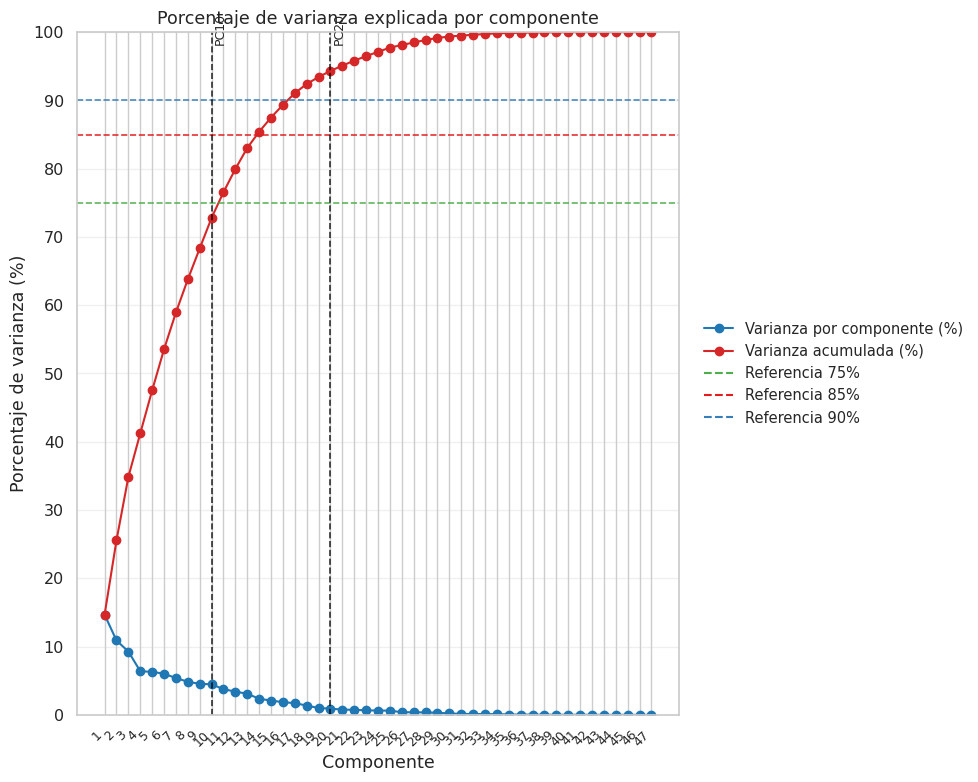

In [10]:
fig, ax = plt.subplots(figsize=(10, 8))

evr = myPCA.explained_variance_ratio_
cum_evr = evr.cumsum()
evr_pct = evr * 100
cum_pct = cum_evr * 100
m = len(evr_pct)
x = np.arange(1, m + 1)

line1, = ax.plot(x, evr_pct, marker='o', color='#1f77b4', label='Varianza por componente (%)', linewidth=1.5)
line2, = ax.plot(x, cum_pct, marker='o', color='#d62728', label='Varianza acumulada (%)', linewidth=1.5)

ref_levels = [75, 85, 90]
ref_colors = ['#4daf4a', '#e41a1c', '#377eb8']
for lvl, col in zip(ref_levels, ref_colors):
    ax.axhline(lvl, color=col, linestyle='--', linewidth=1.2, alpha=0.9)

# líneas verticales en PC10 y PC20 (si existen)
if m >= 10:
    ax.axvline(10, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
    ax.text(10 + 0.2, ax.get_ylim()[1]*0.98, 'PC10', rotation=90, va='top', ha='left', fontsize=9)
if m >= 20:
    ax.axvline(20, color='black', linestyle='--', linewidth=1.2, alpha=0.8)
    ax.text(20 + 0.2, ax.get_ylim()[1]*0.98, 'PC20', rotation=90, va='top', ha='left', fontsize=9)

ax.set_xlabel('Componente')
ax.set_ylabel('Porcentaje de varianza (%)')
ax.set_title('Porcentaje de varianza explicada por componente')

ax.set_xticks(x)
if m > 10:
    ax.set_xticklabels(x, rotation=45, ha='right', fontsize=9)
else:
    ax.set_xticklabels(x)

ax.set_ylim(0, 100)
ax.set_yticks(np.arange(0, 101, 10))
ax.grid(axis='y', alpha=0.3)

from matplotlib.lines import Line2D
data_handles, data_labels = ax.get_legend_handles_labels()
ref_handles = [Line2D([0], [0], color=c, lw=1.5, linestyle='--') for c in ref_colors]
ref_labels = [f'Referencia {int(l)}%' for l in ref_levels]
ax.legend(data_handles + ref_handles, data_labels + ref_labels,
          loc='center left', bbox_to_anchor=(1.02, 0.5), fontsize='small', frameon=False)

plt.tight_layout()
plt.show()

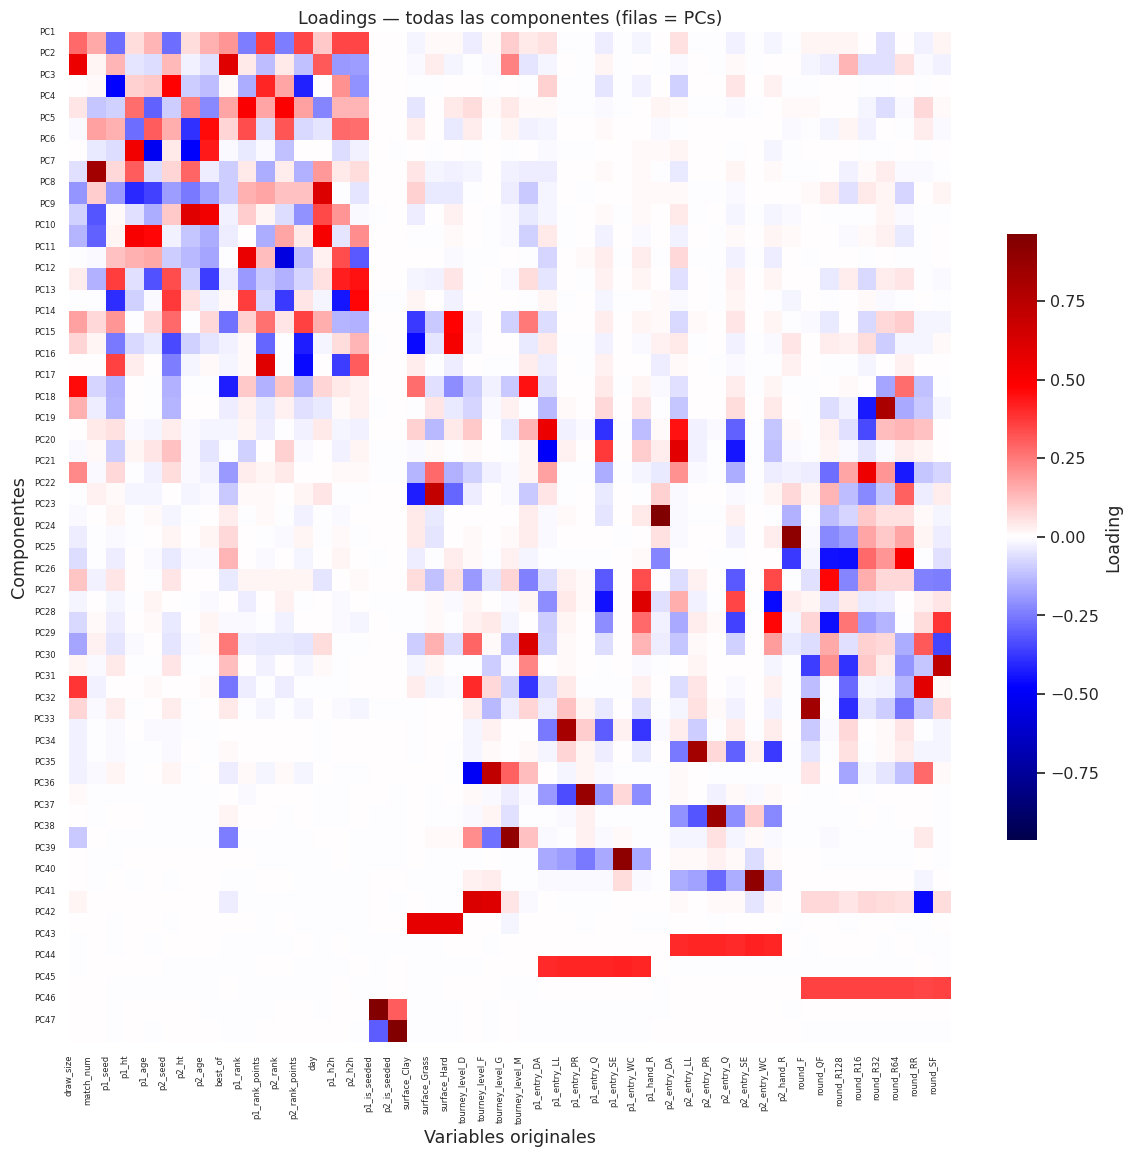

In [11]:
components = myPCA.components_ 
pc_labels = [f'PC{i+1}' for i in range(components.shape[0])]
comp_df = pd.DataFrame(components, index=pc_labels, columns=FEATURE_NAMES)

n_rows, n_cols = comp_df.shape
fig_w = max(12, n_cols * 0.25)
fig_h = max(6, n_rows * 0.25)
fig, ax = plt.subplots(figsize=(fig_w, fig_h))

v = np.max(np.abs(comp_df.values))
sns.heatmap(
    comp_df,cmap='seismic',center=0,annot=False,fmt=".3f",
    vmin=-v,vmax=v,cbar_kws={'label': 'Loading', 'shrink': 0.6},ax=ax
)

ax.set_title('Loadings — todas las componentes (filas = PCs)')
ax.set_xlabel('Variables originales')
ax.set_ylabel('Componentes')

ax.set_xticks(np.arange(n_cols))
if n_cols > 30:
    ax.set_xticklabels(comp_df.columns, rotation=90, fontsize=6)
else:
    ax.set_xticklabels(comp_df.columns, rotation=45, ha='right', fontsize=8)

ax.set_yticks(np.arange(n_rows))
ax.set_yticklabels(comp_df.index, rotation=0, fontsize=max(6, min(9, 200//n_rows)))

plt.tight_layout()
plt.show()

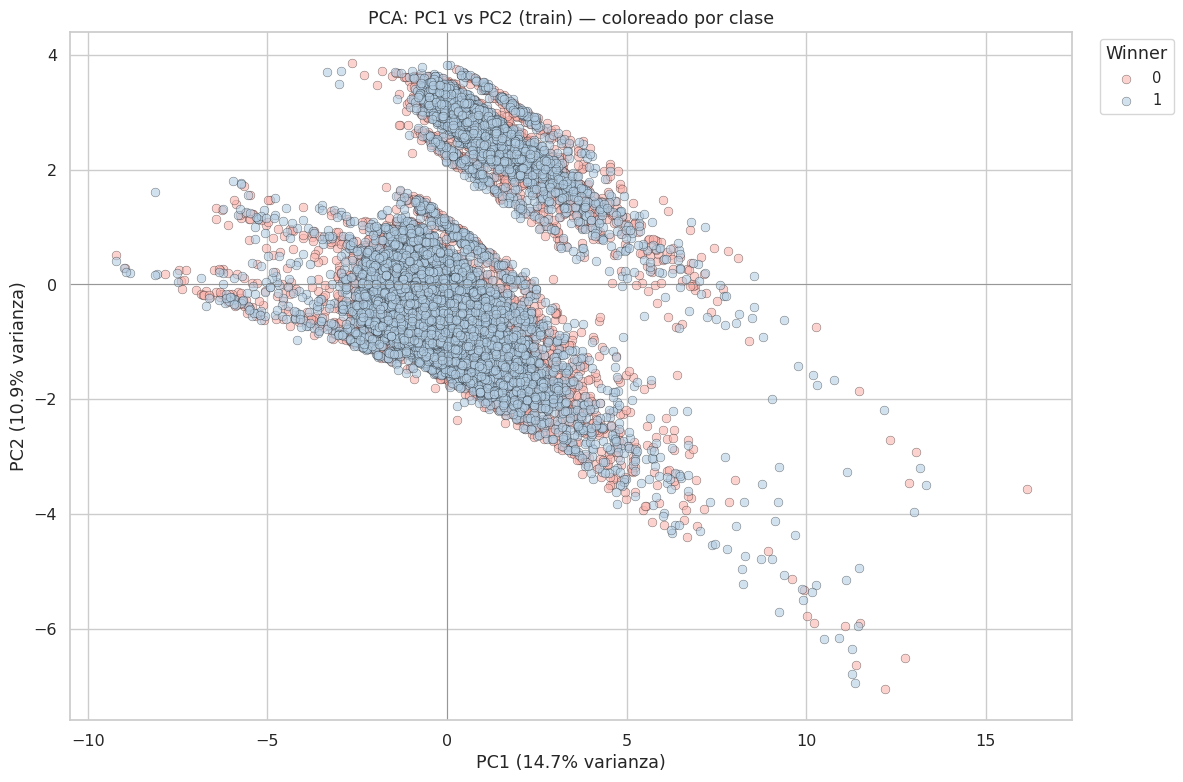

In [12]:
pca_result = myPCA.transform(X_train_processed)
pca_result = np.asarray(pca_result)  # garantizar array numpy

expl_var = myPCA.explained_variance_ratio_ * 100

unique_classes = np.unique(y_train)
palette = sns.color_palette("Pastel1", n_colors=len(unique_classes))
plt.figure(figsize=(12, 8))
ax = plt.gca()

for i, cls in enumerate(unique_classes):
    mask = (y_train.values == cls)
    ax.scatter(
        pca_result[mask, 0],
        pca_result[mask, 1],
        label=cls,
        s=40,
        alpha=0.6,
        edgecolor='black',
        linewidth=0.3,
        color=palette[i % len(palette)]
    )

ax.set_xlabel(f'PC1 ({expl_var[0]:.1f}% varianza)')
ax.set_ylabel(f'PC2 ({expl_var[1]:.1f}% varianza)')
ax.axhline(0, color='grey', linewidth=0.5)
ax.axvline(0, color='grey', linewidth=0.5)
ax.set_title('PCA: PC1 vs PC2 (train) — coloreado por clase')

ax.legend(title=target, bbox_to_anchor=(1.02, 1), loc='upper left', fontsize='small')

plt.tight_layout()
plt.show()

--- 
## C.2-Aplicar t-SNE

In [13]:
from sklearn.manifold import TSNE

tsne = TSNE(
    n_components=2,
    random_state=RND,
    perplexity=30.0,
    learning_rate='auto', 
    n_jobs=-1,            # Paralelizar  
    max_iter=1000,
    verbose=1
)

print("Iniciando ajuste de t-SNE (sobre datos estandarizados)...")

X_train_tsne = tsne.fit_transform(X_train_processed)

Iniciando ajuste de t-SNE (sobre datos estandarizados)...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 25125 samples in 0.005s...
[t-SNE] Computed neighbors for 25125 samples in 0.593s...
[t-SNE] Computed conditional probabilities for sample 1000 / 25125
[t-SNE] Computed conditional probabilities for sample 2000 / 25125
[t-SNE] Computed conditional probabilities for sample 3000 / 25125
[t-SNE] Computed conditional probabilities for sample 4000 / 25125
[t-SNE] Computed conditional probabilities for sample 5000 / 25125
[t-SNE] Computed conditional probabilities for sample 6000 / 25125
[t-SNE] Computed conditional probabilities for sample 7000 / 25125
[t-SNE] Computed conditional probabilities for sample 8000 / 25125
[t-SNE] Computed conditional probabilities for sample 9000 / 25125
[t-SNE] Computed conditional probabilities for sample 10000 / 25125
[t-SNE] Computed conditional probabilities for sample 11000 / 25125
[t-SNE] Computed conditional probabilities for sample 12000 

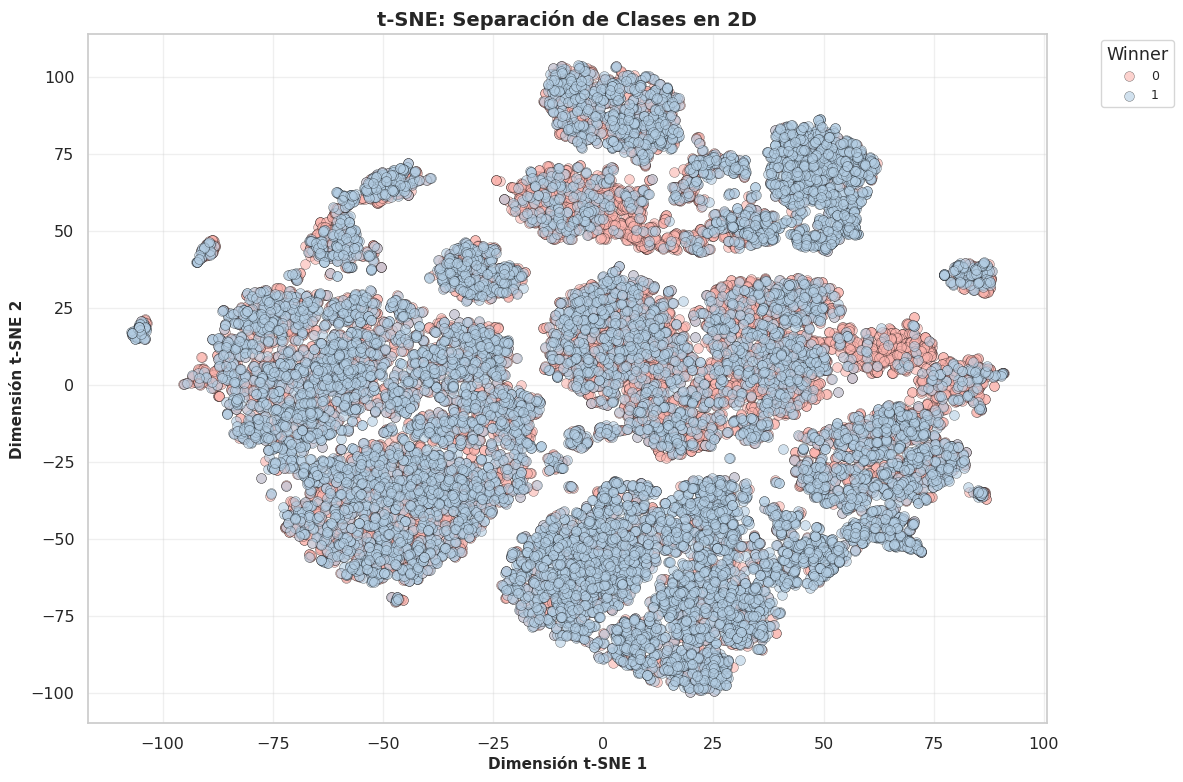

In [14]:
# Visualización en 2D con t-SNE (corregido)
X_train_tsne = np.asarray(X_train_tsne)
unique_classes = np.unique(y_train)
palette = sns.color_palette("Pastel1", n_colors=len(unique_classes))

plt.figure(figsize=(12, 8))
for i, cls in enumerate(unique_classes):
    mask = (y_train.values == cls)        # usar .values para obtener boolean ndarray
    plt.scatter(
        X_train_tsne[mask, 0],
        X_train_tsne[mask, 1],
        label=cls,
        alpha=0.6,
        s=50,
        color=palette[i % len(palette)],
        edgecolors='black',
        linewidth=0.3
    )

plt.xlabel('Dimensión t-SNE 1', fontsize=11, fontweight='bold')
plt.ylabel('Dimensión t-SNE 2', fontsize=11, fontweight='bold')
plt.title('t-SNE: Separación de Clases en 2D', fontsize=14, fontweight='bold')
plt.legend(title=target, bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## C.3-Comentarios sobre la reducción de dimensionalidad

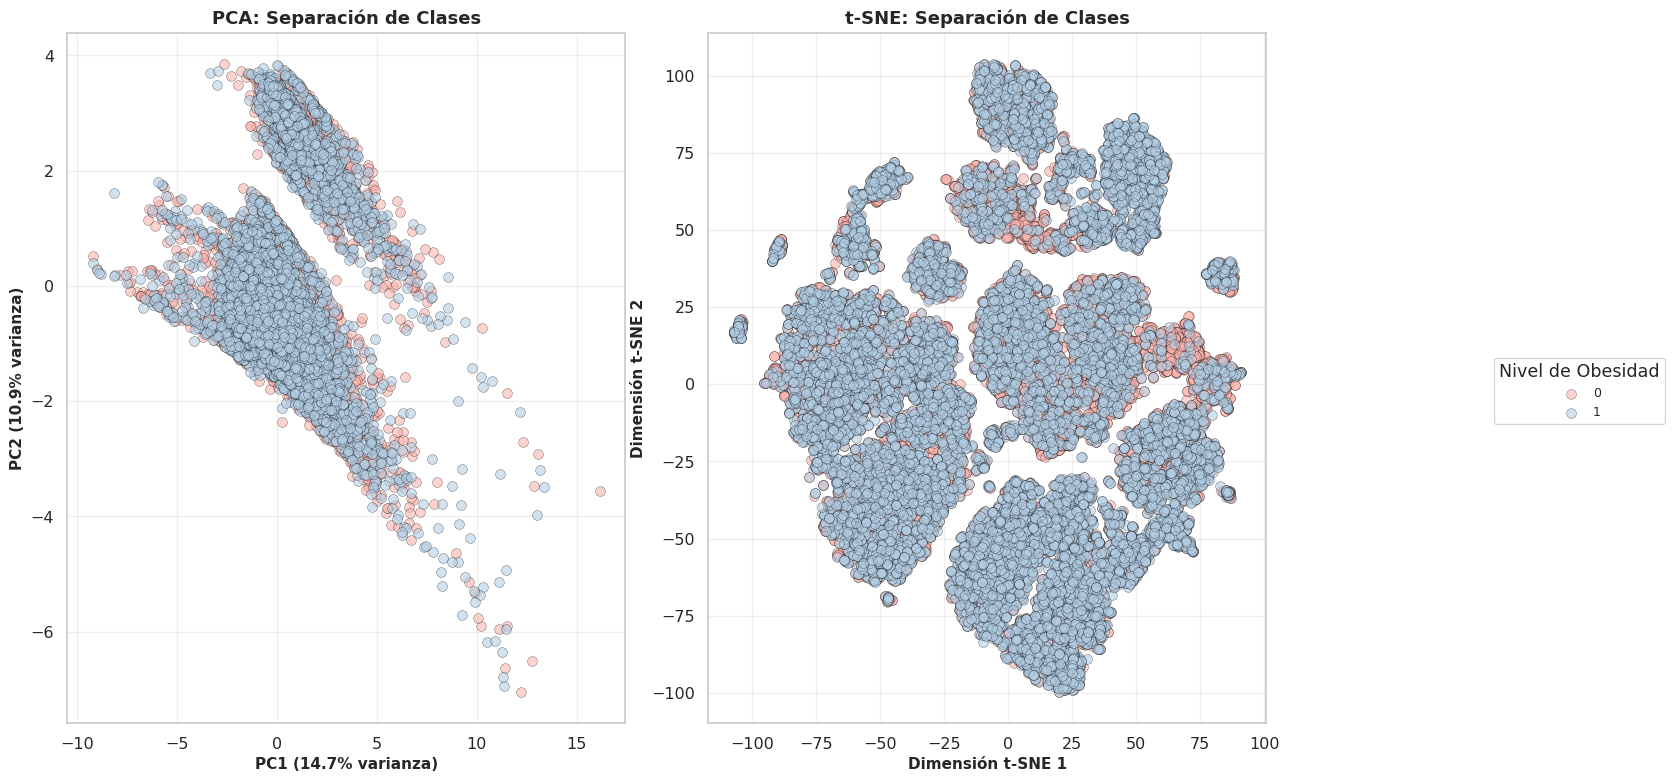

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(15, 8))

X_pca = next((globals().get(n) for n in ('X_train_pca','pca_result') if globals().get(n) is not None), None)
if X_pca is None:
    X_pca = myPCA.transform(X_train_processed)

evr = myPCA.explained_variance_ratio_
palette = sns.color_palette("Pastel1", n_colors=len(np.unique(y_train)))

for i, obesity_class in enumerate(np.unique(y_train)):
    mask = (y_train == obesity_class).values if isinstance(y_train, pd.Series) else (y_train == obesity_class)
    axes[0].scatter(X_pca[mask, 0], X_pca[mask, 1],
                    label=obesity_class, alpha=0.6, s=50,
                    color=palette[i % len(palette)], edgecolors='black', linewidth=0.3)

axes[0].set_xlabel(f'PC1 ({evr[0]*100:.1f}% varianza)', fontsize=11, fontweight='bold')
axes[0].set_ylabel(f'PC2 ({evr[1]*100:.1f}% varianza)', fontsize=11, fontweight='bold')
axes[0].set_title('PCA: Separación de Clases', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)

for i, obesity_class in enumerate(np.unique(y_train)):
    mask = (y_train == obesity_class).values if isinstance(y_train, pd.Series) else (y_train == obesity_class)
    axes[1].scatter(X_train_tsne[mask, 0], X_train_tsne[mask, 1],
                    label=obesity_class, alpha=0.6, s=50,
                    color=palette[i % len(palette)], edgecolors='black', linewidth=0.3)

axes[1].set_xlabel('Dimensión t-SNE 1', fontsize=11, fontweight='bold')
axes[1].set_ylabel('Dimensión t-SNE 2', fontsize=11, fontweight='bold')
axes[1].set_title('t-SNE: Separación de Clases', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Nivel de Obesidad',
           loc='center right', bbox_to_anchor=(1.12, 0.5), fontsize=9)

plt.tight_layout()
plt.subplots_adjust(right=0.85)
plt.show()

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 2-Ajuste a modelos

## 0. Definiciones 

NOTA: Antes de empezar, definiremos las métricas que usaremos durante los ajustes. Partiendo de la matriz de confusión clásica, definida como:

* **TP (Verdaderos Positivos):** El modelo predijo que gana P1 y ganó P1.
* **TN (Verdaderos Negativos):** El modelo predijo que gana P2 (target=0) y ganó P2.
* **FP (Falsos Positivos):** El modelo predijo que gana P1, pero ganó P2.
* **FN (Falsos Negativos):** El modelo predijo que gana P2, pero ganó P1.

Hemos barajado diferentes **scoring systems**:

1. `Accuracy:` Mide el porcentaje total de aciertos sobre el total de partidos.
2. `Precision:` Mide la calidad de las predicciones positivas.
3. `Recall:` Mide la capacidad de encontrar todos los casos positivos.
4: `F1-score:` Es la media armónica entre Precision y Recall.

**Conclusión:** Dado que no existe desbalance de clases y que los errores de predicción son simétricos en coste, maximizaremos el **Accuracy**.



---


Para asegurarnos de que todos los modelos siguen las mismas condiciones y no hay sesgos, vamos a hacer el ajuste con una misma función.

In [16]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, TimeSeriesSplit
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.base import clone
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 1. CONFIGURACIÓN
RND = 16                
MAX_ITER = 1000        
SCORING_SYSTEM = 'accuracy' 
N_CV = 5            

# Corregido el error de 'Cyans' -> Usamos 'GnBu'
COLOR_MAP_ANSI = {
    'Blues': '\033[1;34m',    
    'GnBu': '\033[1;36m',   
    'Purples': '\033[1;35m',  
    'Greens': '\033[1;32m',   
    'Oranges': '\033[1;33m',  
    'Reds': '\033[1;31m',    
    'Greys': '\033[1;37m'    
}
RESET_CODE = '\033[0m'

MODEL_TO_CMAP = {
    'LogisticRegression': 'Blues',
    'KNeighborsClassifier': 'GnBu', # Corregido
    'SVC': 'Purples', 
    'LinearSVC': 'Purples',
    'RandomForestClassifier': 'Greens',
    'XGBClassifier': 'Oranges',
    'MLPClassifier': 'Reds',         
    'VotingClassifier': 'Greys',      
    'StackingClassifier': 'Greys'
}

# 2. FUNCIÓN MAESTRA ADAPTADA A TIME SERIES
def ejecutar_modelo(modelo, params, X_train, y_train, preprocessor=preprocessor, 
                    cv=5, scoring='accuracy', tipo_busqueda='grid', n_iter=20):
    
    # 1. Configuración de TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=cv)
    
    # 2. Pipeline
    steps = []
    if preprocessor:
        steps.append(('preprocessor', preprocessor))
    steps.append(('clf', modelo))
    pipeline = Pipeline(steps)
    
    # 3. Ajuste de nombres de parámetros
    pipeline_params = {f'clf__{k}': v for k, v in params.items()}
    
    model_name = modelo.__class__.__name__
    cmap = MODEL_TO_CMAP.get(model_name, 'Blues')
    ansi_color = COLOR_MAP_ANSI.get(cmap, '\033[1;34m')

    print(f"\n{ansi_color}--- Iniciando entrenamiento de {model_name} ---{RESET_CODE}")
    print(f"Modo: {tipo_busqueda.upper()} search | CV: TimeSeriesSplit ({cv} splits)")

    # 4. BUSQUEDA (Grid o Random)
    if tipo_busqueda == 'grid':
        search = GridSearchCV(
            pipeline, pipeline_params, cv=tscv, scoring=scoring, n_jobs=-1, verbose=1
        )
    elif tipo_busqueda == 'random':
        search = RandomizedSearchCV(
            pipeline, pipeline_params, n_iter=n_iter, cv=tscv, scoring=scoring, 
            n_jobs=1, verbose=1, random_state=RND
        )
    else:
        raise ValueError("tipo_busqueda debe ser 'grid' o 'random'")

    # 5. ENTRENAMIENTO PRINCIPAL
    search.fit(X_train, y_train)
    
    # 6. RESULTADOS DEL GRID
    print(f"\n--- Mejores Parámetros ({model_name}): {search.best_params_} ---")
    print(f"{ansi_color}>>> Best Time-Series CV {scoring.upper()}: {search.best_score_:.4f}{RESET_CODE}")
    
    # --- CORRECCIÓN AQUÍ ---
    # 7. PREDICCIONES HONESTAS (Loop Manual para TimeSeries)
    print("Generando predicciones validación cruzada temporal...")
    
    best_pipeline = search.best_estimator_
    
    # Listas para guardar las predicciones reales y las hechas por el modelo
    actual_y = []
    predicted_y = []
    
    # Iteramos manualmente sobre los splits temporales
    for train_index, test_index in tscv.split(X_train):
        # Clonamos el pipeline para tener uno fresco en cada vuelta
        fold_pipeline = clone(best_pipeline)
        
        # Separamos train y test usando iloc (seguro para pandas)
        X_train_fold, X_test_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_test_fold = y_train.iloc[train_index], y_train.iloc[test_index]
        
        # Entrenamos en el pasado, predecimos el futuro inmediato
        fold_pipeline.fit(X_train_fold, y_train_fold)
        fold_preds = fold_pipeline.predict(X_test_fold)
        
        # Guardamos
        actual_y.extend(y_test_fold)
        predicted_y.extend(fold_preds)

    # Convertimos a arrays para métricas
    y_train_valid = np.array(actual_y)
    y_pred_cv = np.array(predicted_y)

    # 8. REPORTE Y GRÁFICOS
    print(f"\nResultados ({len(y_train_valid)} partidos evaluados):")
    report_dict = classification_report(y_train_valid, y_pred_cv, output_dict=True)
    
    style = pd.DataFrame(report_dict).transpose().style.background_gradient(
        cmap=cmap, subset=['precision', 'recall', 'f1-score'], vmin=0, vmax=1
    ).format("{:.3f}")
    display(style)
    
    fig, ax = plt.subplots(figsize=(5, 4))
    ConfusionMatrixDisplay.from_predictions(y_train_valid, y_pred_cv, cmap=cmap, colorbar=False, ax=ax)
    ax.set_title(f"Confusion Matrix ({model_name})", pad=15)
    ax.grid(False)
    plt.show()
    
    return search

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase A: Modelos líneales/cuadráticos

## A.1-Regresión logística



--- Iniciando entrenamiento de LogisticRegression ---
Modo: GRID search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 84 candidates, totalling 420 fits

--- Mejores Parámetros (LogisticRegression): {'clf__C': np.float64(0.015848931924611134), 'clf__class_weight': 'balanced', 'clf__penalty': 'l1', 'clf__solver': 'liblinear'} ---
>>> Best Time-Series CV ACCURACY: 0.6667
Generando predicciones validación cruzada temporal...

Resultados (20935 partidos evaluados):


,precision,recall,f1-score,support
0,0.661,0.686,0.673,10477.000
1,0.673,0.648,0.660,10458.000
accuracy,0.667,0.667,0.667,0.667
macro avg,0.667,0.667,0.667,20935.000
weighted avg,0.667,0.667,0.667,20935.000


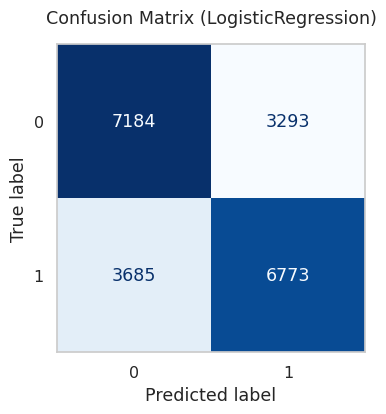

In [17]:
from sklearn.linear_model import LogisticRegression

param_grid_lr = {
    'C': np.logspace(-3, 3, 21),  # 21 valores entre 10^-3 y 10^3
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'class_weight': ['balanced', None]
}

lr_model = LogisticRegression(max_iter=MAX_ITER, random_state=RND)

grid_log = ejecutar_modelo(
    lr_model, 
    param_grid_lr, 
    X_train, 
    y_train
)

best_lr = grid_log.best_estimator_

---

## A.2-K Nearest Neighbors



--- Iniciando entrenamiento de KNeighborsClassifier ---
Modo: GRID search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 60 candidates, totalling 300 fits

--- Mejores Parámetros (KNeighborsClassifier): {'clf__n_neighbors': np.int64(27), 'clf__p': 1, 'clf__weights': 'distance'} ---
>>> Best Time-Series CV ACCURACY: 0.6409
Generando predicciones validación cruzada temporal...

Resultados (20935 partidos evaluados):


,precision,recall,f1-score,support
0,0.632,0.678,0.654,10477.000
1,0.652,0.604,0.627,10458.000
accuracy,0.641,0.641,0.641,0.641
macro avg,0.642,0.641,0.640,20935.000
weighted avg,0.642,0.641,0.640,20935.000


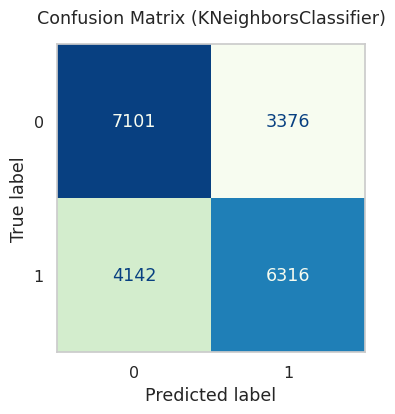

In [18]:
from sklearn.neighbors import KNeighborsClassifier

param_grid_knn = {
    'n_neighbors': np.arange(1, 30, 2),   # Solo impares para evitar empates
    'weights': ['uniform', 'distance'],   
    'p': [1, 2]                           
}

knn_model = KNeighborsClassifier()

grid_knn = ejecutar_modelo(knn_model, param_grid_knn, X_train, y_train)
best_knn = grid_knn.best_estimator_

---

## A.3-SVM líneal


--- Iniciando entrenamiento de LinearSVC ---
Modo: GRID search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 168 candidates, totalling 840 fits

--- Mejores Parámetros (LinearSVC): {'clf__C': np.float64(0.501187233627272), 'clf__class_weight': None, 'clf__fit_intercept': True, 'clf__loss': 'squared_hinge'} ---
>>> Best Time-Series CV ACCURACY: 0.6653
Generando predicciones validación cruzada temporal...

Resultados (20935 partidos evaluados):


,precision,recall,f1-score,support
0,0.662,0.677,0.669,10477.000
1,0.669,0.654,0.661,10458.000
accuracy,0.665,0.665,0.665,0.665
macro avg,0.665,0.665,0.665,20935.000
weighted avg,0.665,0.665,0.665,20935.000


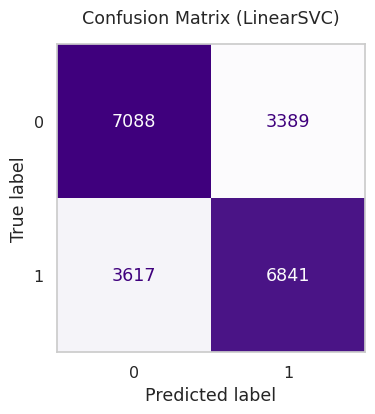

In [19]:
from sklearn.svm import LinearSVC

svm_params = {
    'C': np.logspace(-3, 3, 21),  # 21 valores entre 10^-3 y 10^3
    'loss': ['hinge', 'squared_hinge'],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced']
}

svm_model = LinearSVC(dual=False, random_state=RND, max_iter=MAX_ITER)

# ¡Ahora la llamada es mucho más limpia! No hace falta pasar 'cmap'.
grid_svm = ejecutar_modelo(
    svm_model, 
    svm_params, 
    X_train, 
    y_train
)

best_svm = grid_svm.best_estimator_

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Fase B: Modelos no líneales

## B.1-Random Forest





--- Iniciando entrenamiento de RandomForestClassifier ---
Modo: RANDOM search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- Mejores Parámetros (RandomForestClassifier): {'clf__n_estimators': 40, 'clf__min_samples_leaf': 10, 'clf__max_depth': 15, 'clf__criterion': 'gini'} ---
>>> Best Time-Series CV ACCURACY: 0.6630
Generando predicciones validación cruzada temporal...

Resultados (20935 partidos evaluados):


,precision,recall,f1-score,support
0,0.657,0.683,0.670,10477.000
1,0.669,0.643,0.656,10458.000
accuracy,0.663,0.663,0.663,0.663
macro avg,0.663,0.663,0.663,20935.000
weighted avg,0.663,0.663,0.663,20935.000


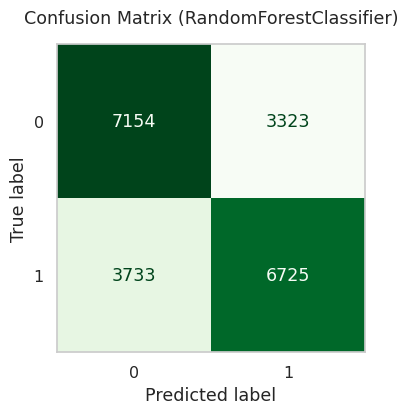

In [20]:
from sklearn.ensemble import RandomForestClassifier

param_grid_rf = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['gini', 'entropy'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10]}

rf_model = RandomForestClassifier(random_state=RND)

grid_rf = ejecutar_modelo(
    rf_model, 
    param_grid_rf, 
    X_train, 
    y_train,
    tipo_busqueda='random',  
    n_iter=20
)

best_rf = grid_rf.best_estimator_

---

## B.2-XGBoost


--- Iniciando entrenamiento de XGBClassifier ---
Modo: RANDOM search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- Mejores Parámetros (XGBClassifier): {'clf__subsample': 0.7, 'clf__n_estimators': 100, 'clf__max_depth': 3, 'clf__learning_rate': 0.05, 'clf__gamma': 0.2, 'clf__colsample_bytree': 0.8} ---
>>> Best Time-Series CV ACCURACY: 0.6660
Generando predicciones validación cruzada temporal...

Resultados (20935 partidos evaluados):


,precision,recall,f1-score,support
0,0.660,0.686,0.673,10477.000
1,0.672,0.646,0.659,10458.000
accuracy,0.666,0.666,0.666,0.666
macro avg,0.666,0.666,0.666,20935.000
weighted avg,0.666,0.666,0.666,20935.000


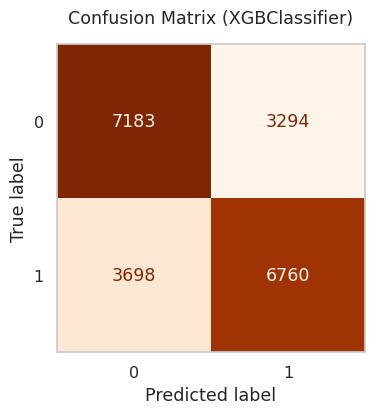

In [21]:
from xgboost import XGBClassifier

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2]
}

xgb_model = XGBClassifier(
    random_state=RND, 
    n_jobs=1, 
    objective='binary:logistic', 
    eval_metric='logloss'
)

grid_xgb = ejecutar_modelo(
    xgb_model, 
    param_grid_xgb, 
    X_train, 
    y_train,
    tipo_busqueda='random',  # These go HERE
    n_iter=20
)
best_xgb = grid_xgb.best_estimator_

---

## B.3-Neural Networks


--- Iniciando entrenamiento de MLPClassifier ---
Modo: RANDOM search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 20 candidates, totalling 100 fits

--- Mejores Parámetros (MLPClassifier): {'clf__learning_rate_init': 0.01, 'clf__hidden_layer_sizes': (50,), 'clf__alpha': 0.01, 'clf__activation': 'relu'} ---
>>> Best Time-Series CV ACCURACY: 0.6291
Generando predicciones validación cruzada temporal...

Resultados (20935 partidos evaluados):


,precision,recall,f1-score,support
0,0.629,0.630,0.630,10477.000
1,0.629,0.628,0.628,10458.000
accuracy,0.629,0.629,0.629,0.629
macro avg,0.629,0.629,0.629,20935.000
weighted avg,0.629,0.629,0.629,20935.000


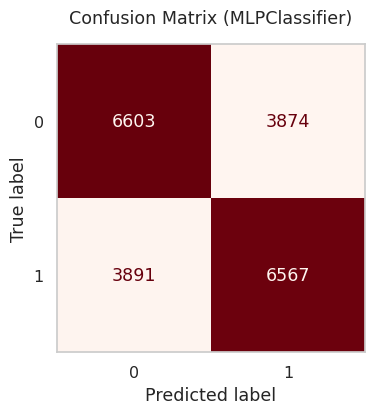

In [22]:
from sklearn.neural_network import MLPClassifier

param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 25), (100, 50)], # Arquitecturas
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001, 0.01],  # Regularización L2
    'learning_rate_init': [0.001, 0.01]
}

mlp_model = MLPClassifier(max_iter=MAX_ITER, random_state=RND)

grid_mlp = ejecutar_modelo(mlp_model, param_grid_mlp, X_train, y_train,    
                           tipo_busqueda='random',  
    n_iter=20)
best_mlp = grid_mlp.best_estimator_

---

## B.4-Ensamble


--- Iniciando entrenamiento de VotingClassifier ---
Modo: RANDOM search | CV: TimeSeriesSplit (5 splits)
Fitting 5 folds for each of 5 candidates, totalling 25 fits

--- Mejores Parámetros (VotingClassifier): {'clf__weights': [2, 1, 1, 2, 2, 1]} ---
>>> Best Time-Series CV ACCURACY: 0.6680
Generando predicciones validación cruzada temporal...

Resultados (20935 partidos evaluados):


,precision,recall,f1-score,support
0,0.662,0.688,0.675,10477.000
1,0.674,0.648,0.661,10458.000
accuracy,0.668,0.668,0.668,0.668
macro avg,0.668,0.668,0.668,20935.000
weighted avg,0.668,0.668,0.668,20935.000


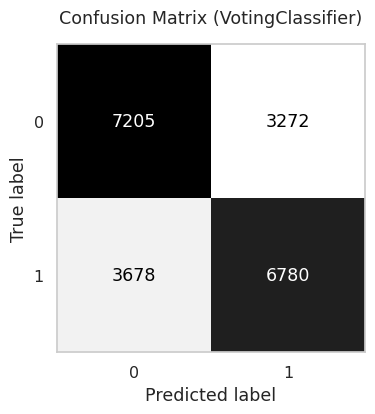

In [23]:
from sklearn.ensemble import VotingClassifier

# Extract just the classifiers from the pipelines (not the full pipeline)
estimators_list = [
    ('lr', best_lr.named_steps['clf']),
    ('knn', best_knn.named_steps['clf']),
    ('svc', best_svm.named_steps['clf']),
    ('rf', best_rf.named_steps['clf']),
    ('xgb', best_xgb.named_steps['clf']),
    ('mlp', best_mlp.named_steps['clf'])
]

voting_model = VotingClassifier(
    estimators=estimators_list,
    voting='hard', 
    n_jobs=1  # Changed to 1 to avoid memory issues
)

# Weights must have 6 elements (one per estimator)
param_grid_voting = {
    'weights': [
        [1, 1, 1, 1, 1, 1],  # Equal weights
        [2, 1, 1, 1, 1, 1],  # Favor LR
        [1, 2, 1, 1, 1, 1],  # Favor KNN
        [1, 1, 2, 1, 1, 1],  # Favor SVC
        [1, 1, 1, 2, 1, 1],  # Favor RF
        [1, 1, 1, 1, 2, 1],  # Favor XGB
        [1, 1, 1, 1, 1, 2],  # Favor MLP
        [2, 1, 1, 2, 2, 1],  # Favor tree-based + LR
        [1, 1, 1, 2, 2, 2],  # Favor non-linear models
    ]
}

grid_voting = ejecutar_modelo(
    voting_model, 
    param_grid_voting, 
    X_train,  
    y_train,
    tipo_busqueda='random',
    n_iter=5  # Only try 5 random combinations to save memory
)

best_voting = grid_voting.best_estimator_

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 3-Comparación de los modelos 

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Parte 4-Conclusiones 

<hr style="height:2px;border:none;color:red;background-color:blue;" />
<hr style="height:2px;border:none;color:red;background-color:red;" />
<hr style="height:2px;border:none;color:red;background-color:blue;" />

# Tiempo total de ejecución

In [24]:
print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 0:21:47.577343
